In [1]:
from scipy.stats import bootstrap
from hierarchy import *
from benlib.plot import scatter_cc, remove_frames, label_bottom_right
set_publication_figure_defaults()

clusters = Clusters(19)
clusters.summarize()
fig_num = 6

NR <= 200:
Anaesthetised: ic: 411, mgb: 190, mgbm:  81, ac: 146, total:  828
Awake:         ic: 148, mgb:   0, mgbm:   0, ac:  63, total:  211
Total:         ic: 559, mgb: 190, mgbm:  81, ac: 209, total: 1039

NR > 200:
Anaesthetised: ic:  16, mgb:  27, mgbm:  25, ac:   5, total:   73
Awake:         ic:   1, mgb:   0, mgbm:   0, ac:   2, total:    3
Total:         ic:  17, mgb:  27, mgbm:  25, ac:   7, total:   76



In [2]:
# load sigmoid fits

# coch_kernel_main is light OFF
# and coch_kernel_opto is light ON

clusters.load_analyses(['coch_kernel_main_sigmoid', 'coch_kernel_opto_sigmoid', 'a2a_kernels_opto_sigmoids'])

Loading "coch kernels light off; elnet, sigmoid"
Fieldname: coch_kernel_main_sigmoid
Found single data file with 1115 clusters
All results present (1115 clusters)

Loading "coch kernels light on; elnet, sigmoid"
Fieldname: coch_kernel_opto_sigmoid
Found single data file with 815 clusters
All results present (815 clusters)

Loading "a2a kernels opto sigmoids (NR=200; all units; all valid data; 1 fold)"
Fieldname: a2a_kernels_opto_sigmoids
Found single data file with 1115 clusters
All results present (815 clusters)



In [3]:
def coch_kernel_light_off_sigmoid_cc_norm_test(cluster, regressor_area=None):
    try:
        return cluster['coch_kernel_main_sigmoid']['sigmoids']['coch_kernel'][-1]['cc_norm_test'][0]
    except:
        return np.nan

def coch_kernel_light_on_sigmoid_cc_norm_test(cluster, regressor_area=None):
    try:
        return cluster['coch_kernel_opto_sigmoid']['sigmoids']['coch_kernel'][-1]['cc_norm_test'][0]
    except:
        return np.nan

# (sanity check) these cc_maax should be identical to linear models (cc_max doesn't depend on model)
def coch_kernel_light_off_sigmoid_cc_max_test(cluster, regressor_area=None):
    try:
        return cluster['coch_kernel_main_sigmoid']['sigmoids']['coch_kernel'][-1]['cc_norm_test'][2]
    except:
        return np.nan

def coch_kernel_light_on_sigmoid_cc_max_test(cluster, regressor_area=None):
    try:
        return cluster['coch_kernel_opto_sigmoid']['sigmoids']['coch_kernel'][-1]['cc_norm_test'][2]
    except:
        return np.nan

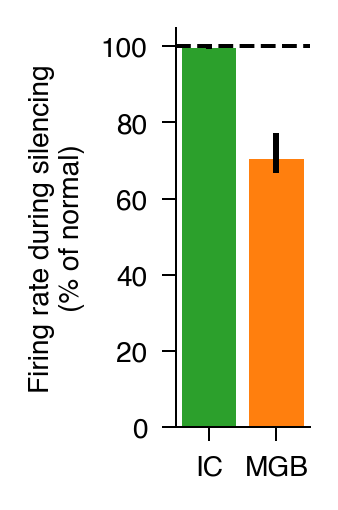

In [4]:
# firing rate
# cluster = clusters.clusters[300]
plt.figure(figsize=(0.6,1.8))

def firing_rate(cluster):
    return np.sum(cluster['light_off']['y_td']), np.sum(cluster['light_on']['y_td'])

sel = clusters.select_data(brain_area='ic', noiseratio=200, optogenetic=True)
rate = [firing_rate(c) for c in sel]
ratio_ic = [100*r[1]/r[0] for r in rate]

sel = clusters.select_data(brain_area='mgb', noiseratio=200, optogenetic=True)
rate = [firing_rate(c) for c in sel]
ratio_mgb = [100*r[1]/r[0] for r in rate]

data = [ratio_ic, ratio_mgb]

mdn = [np.median(d) for d in data]
ci = [bootstrap((d,), np.median) for d in data]
err = [(m-c.confidence_interval.low, c.confidence_interval.high-m) for m,c in zip(mdn,ci)]
err_stack = np.vstack(err).T

plt.bar([0,1],
        mdn,
        yerr=err_stack,
        color=[BRAIN_AREA_COLORS['ic'], BRAIN_AREA_COLORS['mgb']],
        capsize=0, error_kw={'elinewidth': 1.5})

# plt.axhline(coch_mdn, color='k', linestyle='--')
plt.xticks([0,1], [r'IC', r'MGB'])

plt.ylabel('Firing rate during silencing\n(% of normal)')

plt.axhline(100, color='k', linewidth=1, linestyle='--')

remove_frames()

plt.savefig('figure-%d-opto-bar.pdf' % fig_num)

In [5]:
# firing rate as % normal -- medians in IC, MGB
print(mdn)

[99.44960952026776, 70.33291617368454]


In [6]:
clusters.load_analyses(['a2a_kernels_opto_sigmoids'])

Loading "a2a kernels opto sigmoids (NR=200; all units; all valid data; 1 fold)"
Fieldname: a2a_kernels_opto_sigmoids
Found single data file with 1115 clusters
All results present (815 clusters)



In [7]:
def a2a_kernel_light_off_sigmoid_cc_norm_test(cluster, regressor_area):
    try:
        return cluster['a2a_kernels_opto_sigmoids']['sigmoids'][regressor_area][0]['light_off']['cc_norm_test'][0]
    except:
        return np.nan

def a2a_kernel_light_on_sigmoid_cc_norm_test(cluster, regressor_area):
    try:
        return cluster['a2a_kernels_opto_sigmoids']['sigmoids'][regressor_area][0]['light_on']['cc_norm_test'][0]
    except:
        return np.nan

In [8]:
from scipy.stats import kruskal

def nan_kruskal(x_data, y_data):
    valid_idx = np.isfinite(x_data+y_data)
    valid_x = [x for x,y in zip(x_data, y_data) if np.isfinite(x) and np.isfinite(y)]
    valid_y = [y for x,y in zip(x_data, y_data) if np.isfinite(x) and np.isfinite(y)]
    r,p = kruskal(valid_x, valid_y)
    return p

In [9]:
cortex_active_text = 'Cortex active'
cortex_silenced_text = 'Cortex silenced'

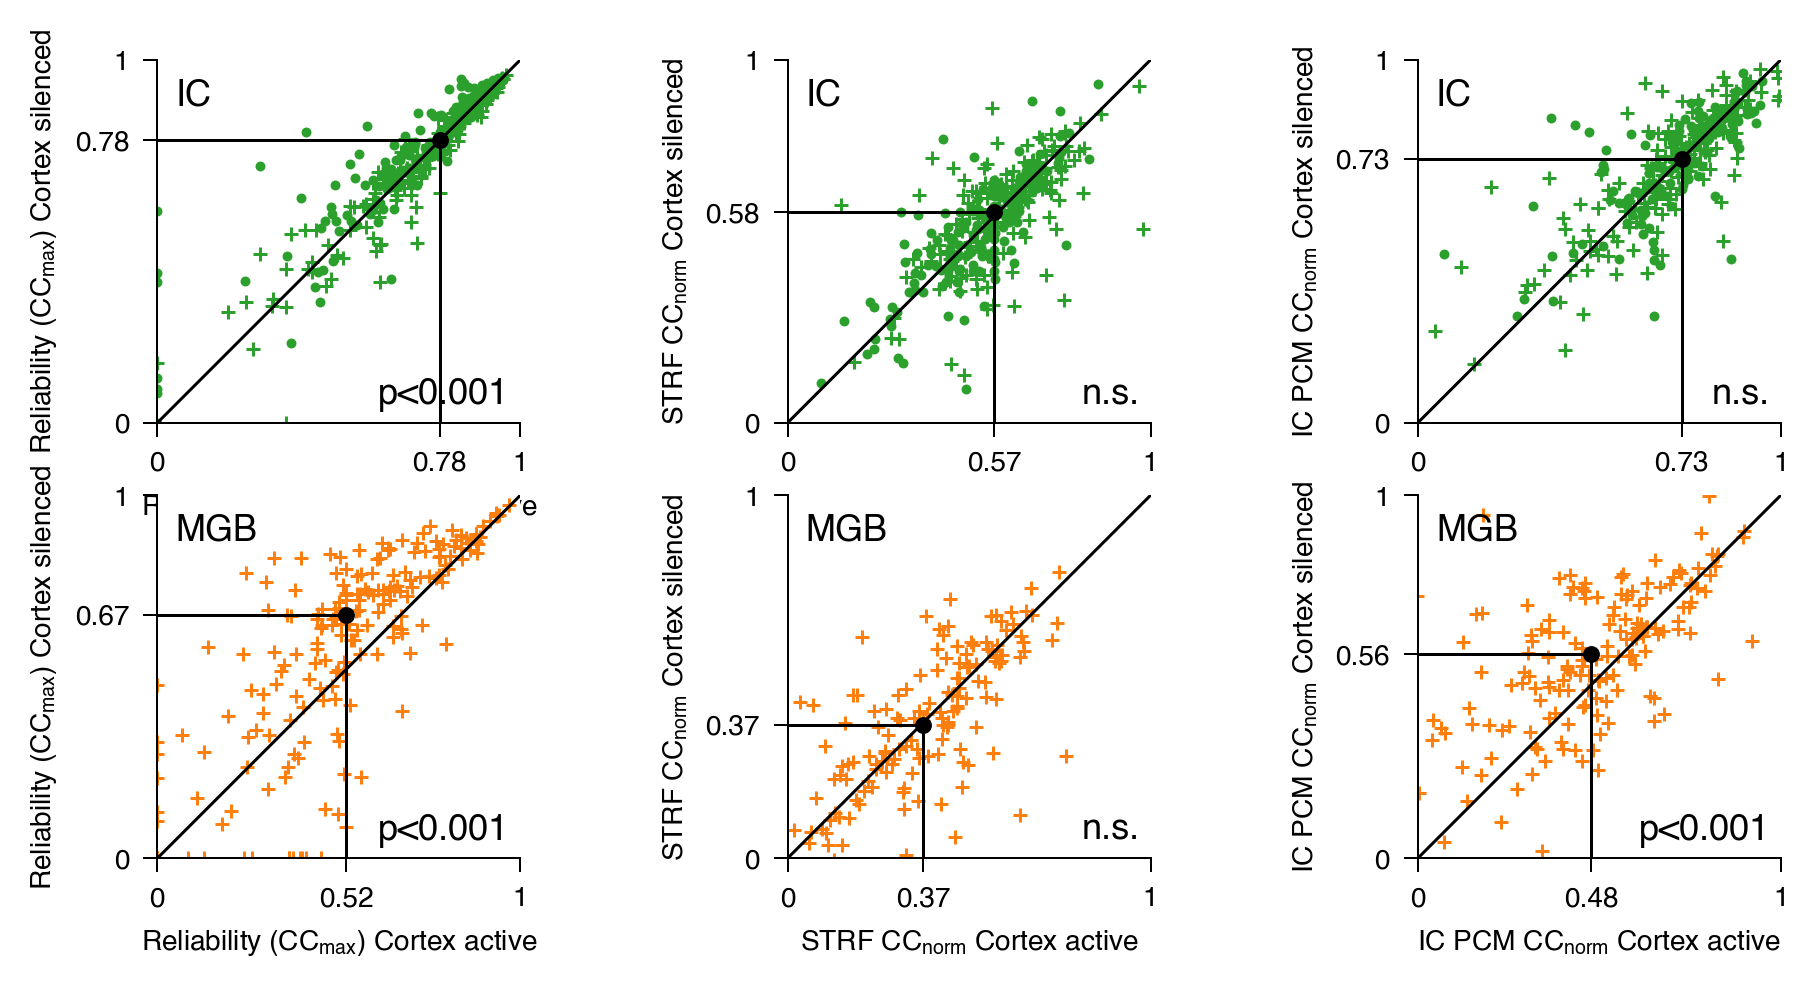

In [10]:
# new version of scatters -- with awake and anaesthetised symbols

fig = plt.figure(figsize=(8,3.6))

ic_awake = clusters.select_data(brain_area='ic', noiseratio=200, state='awake')
ic_anaes = clusters.select_data(brain_area='ic', noiseratio=200, state='anaesthetised')

mgb_awake = clusters.select_data(brain_area='mgb', noiseratio=200, state='awake')
mgb_anaes = clusters.select_data(brain_area='mgb', noiseratio=200, state='anaesthetised')

# IC CC_max
plt.subplot(2,3,1)

x_data_awake = [coch_kernel_light_off_sigmoid_cc_max_test(c) for c in ic_awake]
x_data_anaes = [coch_kernel_light_off_sigmoid_cc_max_test(c) for c in ic_anaes]
y_data_awake = [coch_kernel_light_on_sigmoid_cc_max_test(c) for c in ic_awake]
y_data_anaes = [coch_kernel_light_on_sigmoid_cc_max_test(c) for c in ic_anaes]

scatter_cc_2(x_data_awake, y_data_awake, x_data_anaes, y_data_anaes,
             color1=BRAIN_AREA_COLORS['ic'],
             color2=BRAIN_AREA_COLORS['ic'],
             p_value=True)

plt.text(.05, .95, 'IC', size=9, ha='left', va='top')
plt.xlabel('Reliability ($CC_{max}$) %s' % cortex_active_text)
plt.ylabel('Reliability ($CC_{max}$) %s' % cortex_silenced_text)


# IC CC_norm
plt.subplot(2,3,2)

x_data_awake = [coch_kernel_light_off_sigmoid_cc_norm_test(c) for c in ic_awake]
x_data_anaes = [coch_kernel_light_off_sigmoid_cc_norm_test(c) for c in ic_anaes]
y_data_awake = [coch_kernel_light_on_sigmoid_cc_norm_test(c) for c in ic_awake]
y_data_anaes = [coch_kernel_light_on_sigmoid_cc_norm_test(c) for c in ic_anaes]

scatter_cc_2(x_data_awake, y_data_awake, x_data_anaes, y_data_anaes,
             color1=BRAIN_AREA_COLORS['ic'],
             color2=BRAIN_AREA_COLORS['ic'],
             p_value=True)

plt.text(.05, .95, 'IC', size=9, ha='left', va='top')
plt.xlabel('STRF $CC_{norm}$ %s' % cortex_active_text)
plt.ylabel('STRF $CC_{norm}$ %s' % cortex_silenced_text)


# IC PCM -> IC
plt.subplot(2,3,3)

x_data_awake = [a2a_kernel_light_off_sigmoid_cc_norm_test(c,'ic') for c in ic_awake]
x_data_anaes = [a2a_kernel_light_off_sigmoid_cc_norm_test(c,'ic') for c in ic_anaes]
y_data_awake = [a2a_kernel_light_on_sigmoid_cc_norm_test(c,'ic') for c in ic_awake]
y_data_anaes = [a2a_kernel_light_on_sigmoid_cc_norm_test(c,'ic') for c in ic_anaes]

scatter_cc_2(x_data_awake, y_data_awake, x_data_anaes, y_data_anaes,
             color1=BRAIN_AREA_COLORS['ic'],
             color2=BRAIN_AREA_COLORS['ic'],
             p_value=True)

plt.text(.05, .95, 'IC', size=9, ha='left', va='top')
plt.xlabel('IC PCM $CC_{norm}$ %s' % cortex_active_text)
plt.ylabel('IC PCM $CC_{norm}$ %s' % cortex_silenced_text)

# MGB CC_max
plt.subplot(2,3,4)

x_data_awake = [coch_kernel_light_off_sigmoid_cc_max_test(c) for c in mgb_awake]
x_data_anaes = [coch_kernel_light_off_sigmoid_cc_max_test(c) for c in mgb_anaes]
y_data_awake = [coch_kernel_light_on_sigmoid_cc_max_test(c) for c in mgb_awake]
y_data_anaes = [coch_kernel_light_on_sigmoid_cc_max_test(c) for c in mgb_anaes]

scatter_cc_2(x_data_awake, y_data_awake, x_data_anaes, y_data_anaes,
             color1=BRAIN_AREA_COLORS['mgb'],
             color2=BRAIN_AREA_COLORS['mgb'],
             p_value=True)

plt.text(.05, .95, 'MGB', size=9, ha='left', va='top')
plt.xlabel('Reliability ($CC_{max}$) %s' % cortex_active_text)
plt.ylabel('Reliability ($CC_{max}$) %s' % cortex_silenced_text)

# MGB CC_norm
plt.subplot(2,3,5)

x_data_awake = [coch_kernel_light_off_sigmoid_cc_norm_test(c) for c in mgb_awake]
x_data_anaes = [coch_kernel_light_off_sigmoid_cc_norm_test(c) for c in mgb_anaes]
y_data_awake = [coch_kernel_light_on_sigmoid_cc_norm_test(c) for c in mgb_awake]
y_data_anaes = [coch_kernel_light_on_sigmoid_cc_norm_test(c) for c in mgb_anaes]

scatter_cc_2(x_data_awake, y_data_awake, x_data_anaes, y_data_anaes,
             color1=BRAIN_AREA_COLORS['mgb'],
             color2=BRAIN_AREA_COLORS['mgb'],
             p_value=True)

plt.text(.05, .95, 'MGB', size=9, ha='left', va='top')
plt.xlabel('STRF $CC_{norm}$ %s' % cortex_active_text)
plt.ylabel('STRF $CC_{norm}$ %s' % cortex_silenced_text)

# IC PCM -> MGB
plt.subplot(2,3,6)

x_data_awake = [a2a_kernel_light_off_sigmoid_cc_norm_test(c,'ic') for c in mgb_awake]
x_data_anaes = [a2a_kernel_light_off_sigmoid_cc_norm_test(c,'ic') for c in mgb_anaes]
y_data_awake = [a2a_kernel_light_on_sigmoid_cc_norm_test(c,'ic') for c in mgb_awake]
y_data_anaes = [a2a_kernel_light_on_sigmoid_cc_norm_test(c,'ic') for c in mgb_anaes]

scatter_cc_2(x_data_awake, y_data_awake, x_data_anaes, y_data_anaes,
             color1=BRAIN_AREA_COLORS['mgb'],
             color2=BRAIN_AREA_COLORS['mgb'],
             p_value=True)

plt.text(.05, .95, 'MGB', size=9, ha='left', va='top')
plt.xlabel('IC PCM $CC_{norm}$ %s' % cortex_active_text)
plt.ylabel('IC PCM $CC_{norm}$ %s' % cortex_silenced_text)

remove_frames(fig)

plt.savefig('figure-%d-optogenetic-by-state.pdf' % fig_num)